#Task-1:- Import libraries 

In [ ]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display 
print('Tensorflow version: ', tf.__version__) 

Tensorflow version:  2.3.0


In [ ]:
!pip install plot_utils

     |████████████████████████████████| 13.3MB 220kB/s 


In [ ]:
import plot_utils

#Task-2: Load and Preprocess Dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train  = x_train.astype(np.float32)/255.0
x_test  = x_test.astype(np.float32)/255.0

4423680/4422102 [==============================] - 0s 0us/step


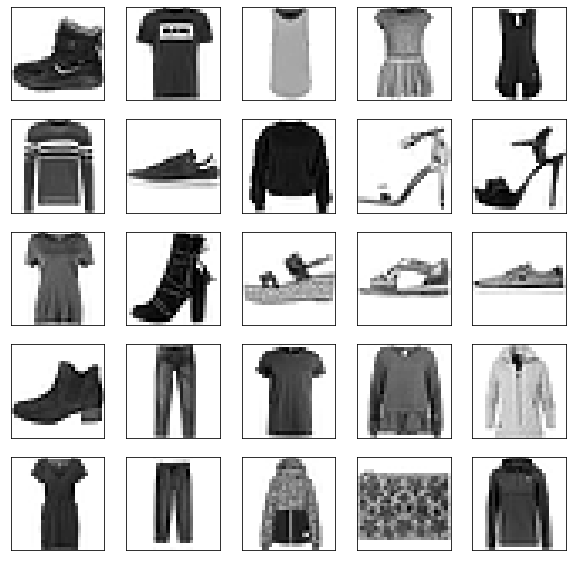

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i], cmap = plt.cm.binary)
plt.show()

# Task 3: Create Batchs for Training Data

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)


# Task 4: Builde the Generator Network for DCGAN

In [ ]:
num_features = 100 #can be anything > 30

generator = keras.models.Sequential([
                                     keras.layers.Dense(7*7*128, input_shape = [num_features]),
                                     keras.layers.Reshape([7,7,128]),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding='same', activation='selu'),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(1,(5,5), (2,2), padding='same', activation='tanh')
])



In [ ]:
noise = tf.random.normal(shape = [1, num_features])
generated_image = generator(noise, training=False)
#plot_utils.show(generated_image, 1)

# Task 5: Build Discriminator Network for DCGAN

In [ ]:
discriminator = keras.models.Sequential([
                                         keras.layers.Conv2D(64, (5,5), (2,2), padding='same', input_shape=[28,28,1]),
                                         keras.layers.LeakyReLU(0.2),
                                         keras.layers.Dropout(0.3),
                                         keras.layers.Conv2D(128, (5,5), (2,2), padding='same'),
                                         keras.layers.LeakyReLU(0.2),
                                         keras.layers.Dropout(0.3),
                                         keras.layers.Flatten(),
                                         keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
dicision = discriminator(generated_image)
print(dicision)

tf.Tensor([[0.4996356]], shape=(1, 1), dtype=float32)


#Task 6: Compile the Deep Convolutional Generative Adversial Network (DCGAN)

In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')


#Task 7: Define Training Procedure

In [ ]:
seed = tf.random.normal(shape=[batch_size, 100])

In [ ]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
  generator, discriminator = gan.layers
  for epoch in tqdm(range(epochs)):
    print("Epochs {}/{}".format(epoch+1, epochs))
    for x_batch in dataset:
      noise = tf.random.normal(shape=[batch_size, num_features])
      generated_images = generator(noise)
      X_fake_and_real = tf.concat([generated_images, x_batch], axis=0)
      y1 = tf.constant([[0.]]*batch_size + [[1.]]*batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)
      y2 = tf.constant([[1.]]*batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)
    
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(predictions[i, :, :, 0]*127.5 + 127.5, cmap='binary')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Task 8: Train DCGAN

In [ ]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1)*2. -1.

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)


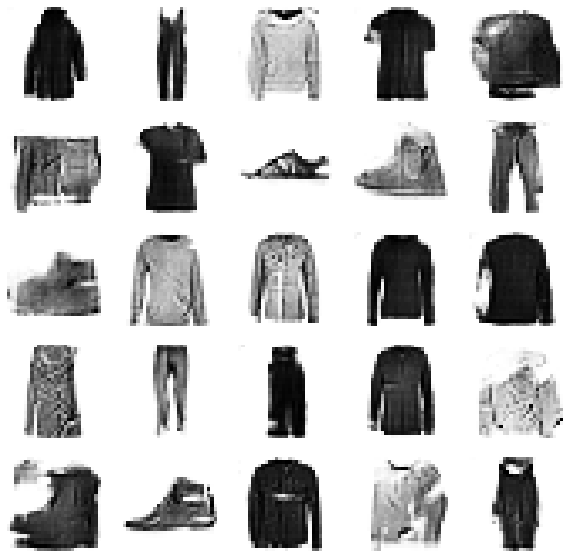

CPU times: user 24min 8s, sys: 1min 25s, total: 25min 34s
Wall time: 26min 29s


In [ ]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=50)


In [ ]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
#plot_utils.show(generated_images, 8)